# Tarea 3 - Ejercicio 1

### Alumno: Marcelo Alberto Sanchez Zaragoza

De acuerdo a lo que nos proporciona la tarea al inicio, hacemos nuestras muestras de distribuciones normales

In [1]:
import matplotlib.pyplot as plt
import numpy as np 
from scipy import stats 
import seaborn as sns 
from math import sqrt,log
import pandas as pd 

In [2]:
## una vez que ya tenemos nuestros datos
n = 500 #propocionamos el tamaño de la muestra
p = 2 #dimension de los datos 
mu1 = [-4,-4]
mu2 = np.repeat(0, p)
s_1 = [[1,0.5],[0.5,1]]
s_2 = [[1,0.1],[0.1,2]]
X = np.random.multivariate_normal(mu1, s_1, n)
X2 = np.random.multivariate_normal(mu2, s_2, n)

In [3]:
m = pd.DataFrame(X,columns = ['x1', 'x2']) ## X a
p = pd.DataFrame(X2, columns = ['x1', 'x2']) ## X2 b

In [4]:
#sns.relplot(x='x1', y='x2', data = m,height=8)
l_f = []
z = []
for i in range(2*n):
    if(i<500):
        l_f.append(m.iloc[i,:])
        z.append("a")
    else:
        l_f.append(p.iloc[i-500,:])
        z.append("b")
f1 = pd.DataFrame(l_f)
f1['Grupo'] = z

Visualizamos nuestros datos, nos damos una idea la cantidad de ellos y su respectivo grupo. Igual vemos que tan lejos están.

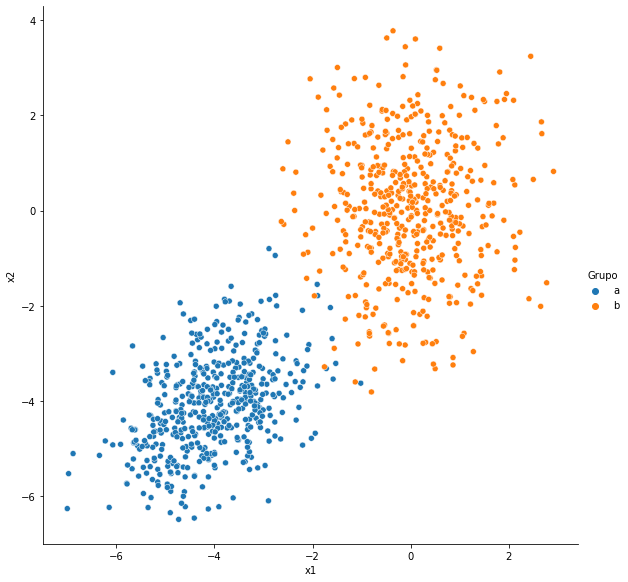

In [5]:
sns.relplot(x='x1', y='x2', hue='Grupo', data = f1,height=8)

Una vez que tenemos nuestros datos vamos a usar el algoritmo MMG-EM.
    Como primer paso vamos a proporcionar valores iniciales para agrupar cada, es decir, los valores de $w$, $\mu$ y $\Sigma$

In [6]:
from scipy.stats import multivariate_normal
#var = multivariate_normal(mean=[0,0], cov=[[1,0],[0,1]])
#var.pdf([1,0])
## Tomares valores 
N = 2*n

### ya iniciamos nuestros datos ahora vamos a colocar cada dato en algun "grupo", es decir, k
###### Con esta funcion podemos saber a que grupo pertenece cada dato porque 
def prob(data, mu1, mu2, S1, S2,w):
    proba1 = multivariate_normal(mean=mu1, cov=S1)
    proba2 = multivariate_normal(mean=mu2, cov=S2)
    k = [] ## grupo que pertenece y la probabilidad que tiene cada dato 
    for i in range(1000):
        a = w[0]*proba1.pdf([data.iloc[i,0], data.iloc[i,1]])
        b = w[1]*proba2.pdf([data.iloc[i,0], data.iloc[i,1]])
        if(a/(a+b) > b/(a+b)):
            k.append(["a",a])
        else:
            k.append(["b",b])
    k1 = pd.DataFrame(k)
    return k1

########### 
## actualizamos los valores de los pesos 
def peso(k):
    contador1 = 0
    contador2 = 0
    suma1 = 0
    suma2 = 0
    for i in range(1000):
        if(k.iloc[i,0] == 'a'):
            contador1 = contador1 +1
            suma1 = suma1 + k.iloc[i,1]
        else:
            contador2 = contador2 +1
            suma2 = suma2 + k.iloc[i,1]
    p1 = suma1/contador1
    p2 = suma2/contador2
    w = [p1, p2] 
    w1 = pd.DataFrame(w)
    return(w1)

### actualizamos los valores de la media 
def medias(k, data):
    contador1 = 0
    contador2 = 0
    su_me = 0
    su_me2 = 0
    for i in range(1000):
        if(k.iloc[i,0] == 'a'):
            contador1 = k.iloc[i,1]+contador1
            su_me = data.iloc[i,0:2]*(k.iloc[i,1]) + su_me
        else:
            #contador2 = contador2 +1
            contador2 = k.iloc[i,1]+contador2
            su_me2 = data.iloc[i,0:2]*(k.iloc[i,1]) + su_me2
    mu_1 = su_me/contador1
    mu_2 = su_me2/contador2
    return(mu_1, mu_2)

#### actualizamos las matrices de varianzas y covarianzas 
def varAct(k, m1,data):
    suma = 0
    suma2 = 0
    m_a = pd.DataFrame([[0,0],[0,0]])
    m_a2 = pd.DataFrame([[0,0],[0,0]])
    for i in range(1000):
        if(k.iloc[i,0] == 'a'):
            s1 = data.iloc[i,0]-m1[0]
            s2 = data.iloc[i,1]-m1[1]
            m_a = pd.DataFrame([[(k.iloc[i,1])*s1**2, (k.iloc[i,1])*s1*s2],[(k.iloc[i,1])*(s1*s2), (k.iloc[i,1])*s2**2]]) + m_a
            suma = k.iloc[i,1] + suma   
    return (m_a,suma)

def varAct2(k, m1,data):
    suma = 0
    m_a = pd.DataFrame([[0,0],[0,0]])
    for i in range(1000):
        if(k.iloc[i,0] == 'b'):
            s1 = data.iloc[i,0]-m1[0]
            s2 = data.iloc[i,1]-m1[1]
            m_a = pd.DataFrame([[(k.iloc[i,1])*s1**2, (k.iloc[i,1])*s1*s2],[(k.iloc[i,1])*(s1*s2), (k.iloc[i,1])*s2**2]]) + m_a
            suma = k.iloc[i,1] + suma   
    return (m_a,suma)

In [7]:
### Proporcionamos unos valores iniciales de forma aleatoria
w = [0.35,0.65]
m1 = [-5,-5]
m2 = [0.2,0.2]
s1 = [[1.1,0.2],[0.2,1.1]]
s2 = [[0.8,0.1],[0.1,1.5]]


#mu1 = [-2,-2]
#mu2 = np.repeat(0, p)
#s_1 = [[1,0.5],[0.5,1]]
#s_2 = [[1,0.1],[0.1,2]]


f = prob(f1, m1, m2, s1, s2, w)
feo = peso(f)
z = medias(f, f1)
beto = varAct(f, m1, f1)
varianza1 = beto[0]/beto[1] ## actualizo la primera matriz de valores
varianza1 = varianza1.values.tolist()
    
beto2 = varAct2(f, m2, f1)
varianza2 = beto2[0]/beto2[1] ## actualizo la segunda matriz de valores
varianza2 = varianza2.values.tolist ()

### Realizamos la primera iteración de la regla de paro

proba1 = multivariate_normal(mean=z[0], cov=varianza1)
proba2 = multivariate_normal(mean=z[1], cov=varianza2)

suma_1 = 0
suma_2 = 0
for i in range(1000):
    if(f.iloc[i,0] == 'a'):
        suma_1 =  feo.iloc[0]*proba1.pdf([f1.iloc[i,0], f1.iloc[i,1]]) + suma_1
    else:
        suma_2 = feo.iloc[1]*proba2.pdf([f1.iloc[i,0], f1.iloc[i,1]]) + suma_2
suma_T = log(suma_1) + log(suma_2)
suma_T2 = 10000000
diferencia = 0#abs(suma_T - suma_T2)

while(diferencia > 0.0002):
##### En esta parte actualizamos cada una de las matrices y vectores ya que las volveremos a ocupar
    suma_T2 = suma_T
    w = [feo.iloc[0,0],feo.iloc[1,0]]
    m1 = z[0]
    m2 = z[1]
    s1 = varianza1
    s2 = varianza2
    f = prob(f1, m1, m2, s1, s2, w)

    feo = peso(f)

    z = medias(f, f1)
    beto = varAct(f, m1, f1)

    varianza1 = beto[0]/beto[1] ## actualizo la primera matriz de valores
    varianza1 = varianza1.values.tolist()
    
    beto2 = varAct2(f, m2, f1)
    varianza2 = beto2[0]/beto2[1] ## actualizo la segunda matriz de valores
    varianza2 = varianza2.values.tolist ()

    ### Realizamos la primera iteración de la regla de paro

    proba1 = multivariate_normal(mean=z[0], cov=varianza1)
    proba2 = multivariate_normal(mean=z[1], cov=varianza2)

    suma_1 = 0
    suma_2 = 0
    for i in range(1000):
        if(f.iloc[i,0] == 'a'):
            suma_1 =  feo.iloc[0]*proba1.pdf([f1.iloc[i,0], f1.iloc[i,1]]) + suma_1
        else:
            suma_2 = feo.iloc[1]*proba2.pdf([f1.iloc[i,0], f1.iloc[i,1]]) + suma_2
#### Realizamos la resta para encontrar esta diferencia que nos ayudara a detener el proceso
    suma_T = log(suma_1) + log(suma_2)
    diferencia = abs(suma_T) - abs(suma_T2)

In [8]:
p=[]
for i in range(1000):
    l = [f1.iloc[i,0],f1.iloc[i,1],f.iloc[i,0]]
    p.append(l)
f_f = pd.DataFrame(p, columns = ['x1','x2','nombre'])

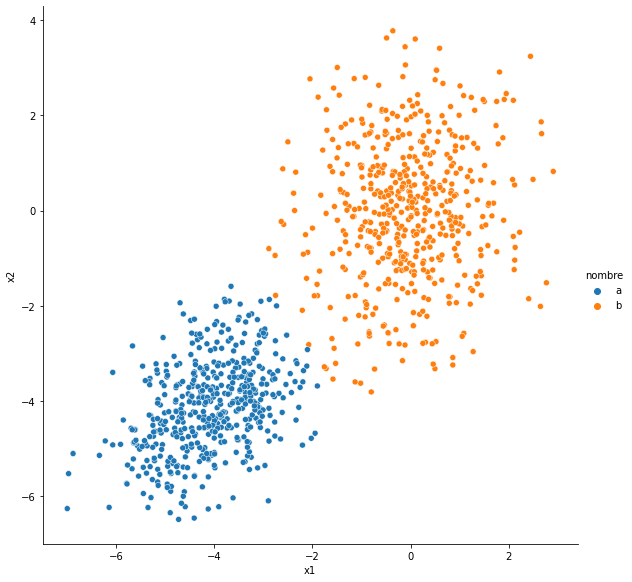

In [9]:
#### Finalmente realizamos la grafica para poder observar los valores en cada grupo
sns.relplot(x='x1', y='x2', hue='nombre', data = f_f,height=8)

In [10]:
from sklearn_extensions.fuzzy_kmeans import KMedians, FuzzyKMeans
f_fuzzy = f_f.iloc[:,0:2]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [12]:
fuzzy_kmeans = FuzzyKMeans(k=2, m=2)
fuzzy_kmeans.fit(f_fuzzy)
#dir(fuzzy_kmeans)
res = pd.DataFrame(np.round(fuzzy_kmeans.fuzzy_labels_,3)).assign(label=fuzzy_kmeans.labels_)

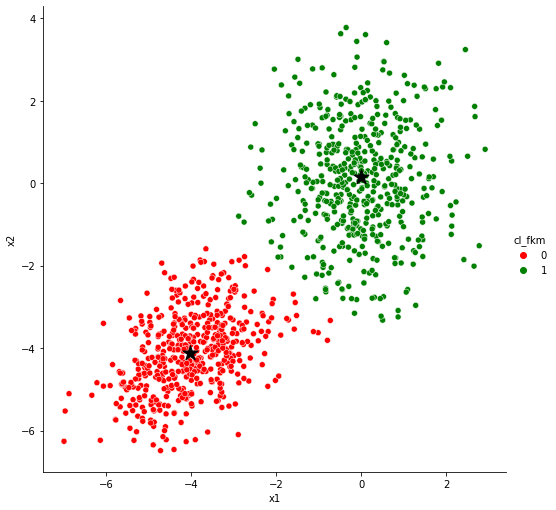

In [13]:
data_toy_fkm = pd.DataFrame(f_fuzzy).assign(cl_fkm = fuzzy_kmeans.labels_)

custom_palette = ["red", "green"]
sns.relplot(x='x1', y='x2', data = data_toy_fkm, hue='cl_fkm', height=7, palette = custom_palette,
           legend = 'brief')
# plot the centroids
plt.scatter(
    fuzzy_kmeans.cluster_centers_[:, 0], fuzzy_kmeans.cluster_centers_[:, 1],
    s=250, marker='*',
    c='black', edgecolor='black',
    label='centroids'
)
#plt.legend(scatterpoints=1)
plt.show()

# Hacemos el inciso c)

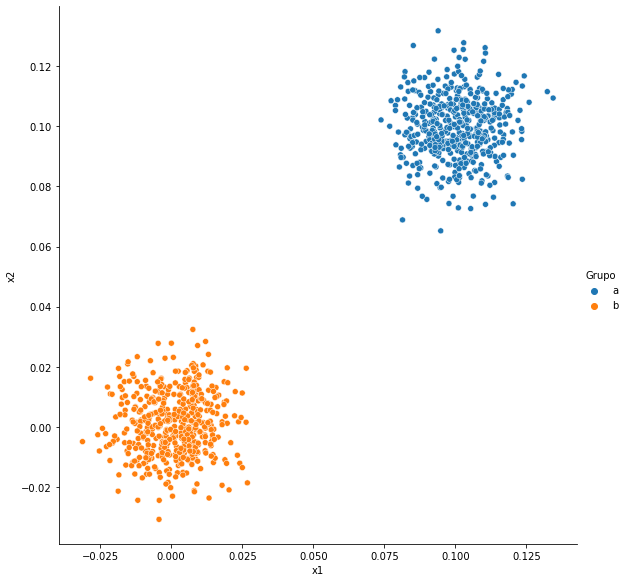

In [26]:
n = 500
p = 2 #dimension de los datos 
mu1 = [0.1,0.1]
mu2 = np.repeat(0, p)
s_1 = [[0.0001,0],[0,0.0001]]
s_2 = [[0.0001,0],[0,0.0001]]
X = np.random.multivariate_normal(mu1, s_1, n)
X2 = np.random.multivariate_normal(mu2, s_2, n)

m = pd.DataFrame(X,columns = ['x1', 'x2']) ## X a
p = pd.DataFrame(X2, columns = ['x1', 'x2']) ## X2 b

l_f = []
z = []
for i in range(2*n):
    if(i<500):
        l_f.append(m.iloc[i,:])
        z.append("a")
    else:
        l_f.append(p.iloc[i-500,:])
        z.append("b")
f1 = pd.DataFrame(l_f)
f1['Grupo'] = z

sns.relplot(x='x1', y='x2', hue='Grupo', data = f1,height=8)

In [32]:
### Proporcionamos unos valores iniciales de forma aleatoria
w = [0.35,0.65]
m1 = [0.1,0.1]
m2 = [0,0]
s1 = [[0.001, 0],[0, 0.001]]
s2 = [[0.001, 0],[0, 0.001]]

f = prob(f1, m1, m2, s1, s2, w)
feo = peso(f)
z = medias(f, f1)
beto = varAct(f, m1, f1)
varianza1 = beto[0]/beto[1] ## actualizo la primera matriz de valores
varianza1 = varianza1.values.tolist()
    
beto2 = varAct2(f, m2, f1)
varianza2 = beto2[0]/beto2[1] ## actualizo la segunda matriz de valores
varianza2 = varianza2.values.tolist ()

### Realizamos la primera iteración de la regla de paro

proba1 = multivariate_normal(mean=z[0], cov=varianza1)
proba2 = multivariate_normal(mean=z[1], cov=varianza2)

suma_1 = 0
suma_2 = 0
for i in range(1000):
    if(f.iloc[i,0] == 'a'):
        suma_1 =  feo.iloc[0]*proba1.pdf([f1.iloc[i,0], f1.iloc[i,1]]) + suma_1
    else:
        suma_2 = feo.iloc[1]*proba2.pdf([f1.iloc[i,0], f1.iloc[i,1]]) + suma_2
suma_T = log(suma_1) + log(suma_2)
suma_T2 = 10000000
diferencia = 0#abs(suma_T - suma_T2)

while(diferencia > 0.0002):
##### En esta parte actualizamos cada una de las matrices y vectores ya que las volveremos a ocupar
    suma_T2 = suma_T
    w = [feo.iloc[0,0],feo.iloc[1,0]]
    m1 = z[0]
    m2 = z[1]
    s1 = varianza1
    s2 = varianza2
    f = prob(f1, m1, m2, s1, s2, w)

    feo = peso(f)

    z = medias(f, f1)
    beto = varAct(f, m1, f1)

    varianza1 = beto[0]/beto[1] ## actualizo la primera matriz de valores
    varianza1 = varianza1.values.tolist()
    
    beto2 = varAct2(f, m2, f1)
    varianza2 = beto2[0]/beto2[1] ## actualizo la segunda matriz de valores
    varianza2 = varianza2.values.tolist ()

    ### Realizamos la primera iteración de la regla de paro

    proba1 = multivariate_normal(mean=z[0], cov=varianza1)
    proba2 = multivariate_normal(mean=z[1], cov=varianza2)

    suma_1 = 0
    suma_2 = 0
    for i in range(1000):
        if(f.iloc[i,0] == 'a'):
            suma_1 =  feo.iloc[0]*proba1.pdf([f1.iloc[i,0], f1.iloc[i,1]]) + suma_1
        else:
            suma_2 = feo.iloc[1]*proba2.pdf([f1.iloc[i,0], f1.iloc[i,1]]) + suma_2
#### Realizamos la resta para encontrar esta diferencia que nos ayudara a detener el proceso
    suma_T = log(suma_1) + log(suma_2)
    diferencia = abs(suma_T) - abs(suma_T2)

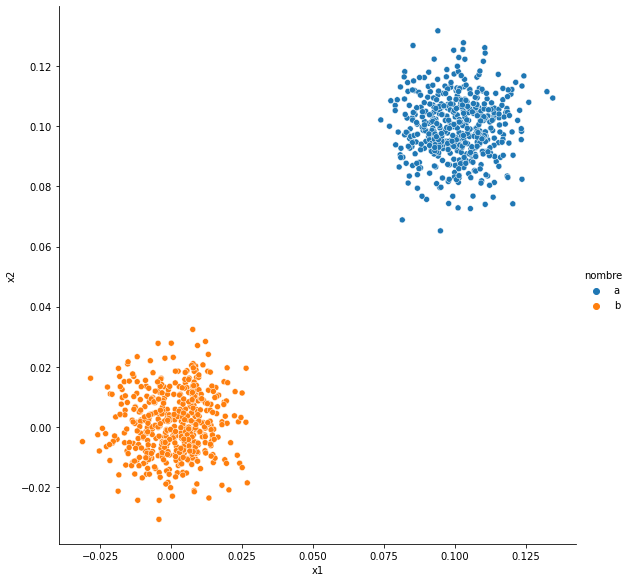

In [33]:
p=[]
for i in range(1000):
    l = [f1.iloc[i,0],f1.iloc[i,1],f.iloc[i,0]]
    p.append(l)
f_f = pd.DataFrame(p, columns = ['x1','x2','nombre'])
sns.relplot(x='x1', y='x2', hue='nombre', data = f_f,height=8)

In [34]:
f_fuzzy = f_f.iloc[:,0:2]
data_toy = pd.DataFrame(f_fuzzy)
data_toy.columns = ['x1','x2']

## k-means

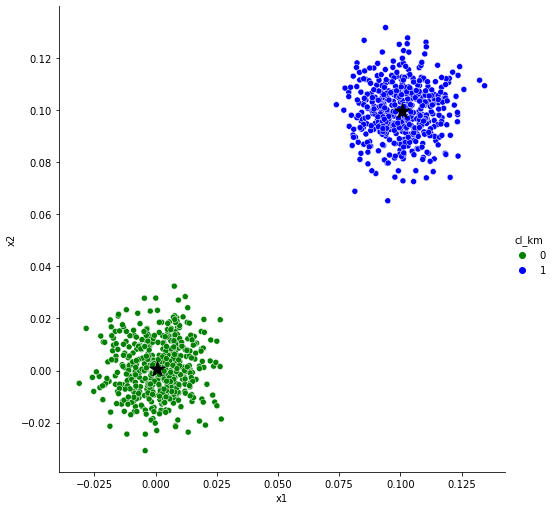

In [35]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=0)
y_km = kmeans.fit_predict(f_fuzzy)

data_toy_km = pd.DataFrame(data_toy).assign(cl_km = y_km)

custom_palette = ["green", "blue"]
sns.relplot(x='x1', y='x2', data = data_toy_km, hue='cl_km', height=7, palette = custom_palette,
           legend = 'brief')

# plot the centroids
plt.scatter(
    kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
    s=250, marker='*',
    c='black', edgecolor='black',
    label='centroids'
) 
#plt.legend(scatterpoints=1)
plt.show()

In [ ]:
fff